In [1]:
from greedy_mcmc_attack import *
from data_collection.recordings import *
import sys
sys.path.append("../../")
from src.models.gcn import *
from src.models.gat import *
from src.models.gsage import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Citeseer')
data = cora_dataset[0].to(device)
print(data)
trials = 5

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [4]:
edges_to_add = None

In [5]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [6]:
model_save_path = "../models/citeseer_gcn_model.pth"
list_save_path = "../attacks/citeseer_gcn_edges_full_run.pth"
# # multi_metattack_edges_list.pth
# list_save_path = "multi_metattack_edges_list.pth"

In [7]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, model, device)

In [8]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.581
Initial Loss: 3.921365737915039


In [9]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.20)

In [10]:
full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j] = [], [], []
for _ in range(trials):
    acc, loss, itrs = two_phase_attack_mcmc(data, train, model, 0.0, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)
    full_metattack_acc.append(acc)
    full_metattack_loss.append(loss)
    full_metattack_itrs.append(itrs)

Peturbing graph...:   0%|          | 0/455 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/455 [00:00<?, ?it/s]

In [11]:
# splits = [0.0, 0.5, 0.7, 0.9]
splits = [0.0, 0.5]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [12]:
# for s in splits:
#     if s == 0.0:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 6, Selected: 0
Attempt: 16, Selected: 10
Attempt: 26, Selected: 20
Attempt: 37, Selected: 30
Attempt: 49, Selected: 40
Attempt: 60, Selected: 50
Attempt: 73, Selected: 60
Attempt: 74, Selected: 60
Attempt: 84, Selected: 70
Attempt: 95, Selected: 80
Attempt: 109, Selected: 90
Attempt: 123, Selected: 100
Attempt: 124, Selected: 100
Attempt: 125, Selected: 100
Attempt: 126, Selected: 100
Attempt: 137, Selected: 110
Attempt: 149, Selected: 120
Attempt: 160, Selected: 130
Attempt: 161, Selected: 130
Attempt: 172, Selected: 140
Attempt: 183, Selected: 150
Attempt: 193, Selected: 160


Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 6, Selected: 0
Attempt: 16, Selected: 10
Attempt: 26, Selected: 20
Attempt: 37, Selected: 30
Attempt: 49, Selected: 40
Attempt: 60, Selected: 50
Attempt: 72, Selected: 60
Attempt: 83, Selected: 70
Attempt: 95, Selected: 80
Attempt: 110, Selected: 90
Attempt: 124, Selected: 100
Attempt: 137, Selected: 110
Attempt: 149, Selected: 120
Attempt: 160, Selected: 130
Attempt: 172, Selected: 140
Attempt: 182, Selected: 150
Attempt: 193, Selected: 160
Attempt: 205, Selected: 170
Attempt: 219, Selected: 180
Attempt: 233, Selected: 190
Attempt: 243, Selected: 200
Attempt: 253, Selected: 210
Attempt: 264, Selected: 220
Attempt: 274, Selected: 230


Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 13, Selected: 10
Attempt: 23, Selected: 20
Attempt: 33, Selected: 30
Attempt: 46, Selected: 40
Attempt: 47, Selected: 40
Attempt: 57, Selected: 50
Attempt: 68, Selected: 60
Attempt: 79, Selected: 70
Attempt: 89, Selected: 80
Attempt: 100, Selected: 90
Attempt: 101, Selected: 90
Attempt: 115, Selected: 100
Attempt: 131, Selected: 110
Attempt: 132, Selected: 110
Attempt: 142, Selected: 120
Attempt: 155, Selected: 130
Attempt: 166, Selected: 140
Attempt: 177, Selected: 150
Attempt: 187, Selected: 160
Attempt: 198, Selected: 170
Attempt: 210, Selected: 180
Attempt: 228, Selected: 190
Attempt: 239, Selected: 200
Attempt: 249, Selected: 210
Attempt: 259, Selected: 220
Attempt: 270, Selected: 230
Attempt: 280, Selected: 240
Attempt: 290, Selected: 250
Attempt: 291, Selected: 250
Attempt: 292, Selected: 250
Attempt: 293, Selected: 250
Attempt: 294, Selected: 250
Attempt: 305, Selected: 260
Attempt: 316, Selected: 270
Attempt: 327, Selected: 280
Attempt: 337, Se

In [13]:
# record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CITESEER, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.REVERSED)
# record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"citeseer"}_{"constant"}_{"reversed"}_results.pkl')

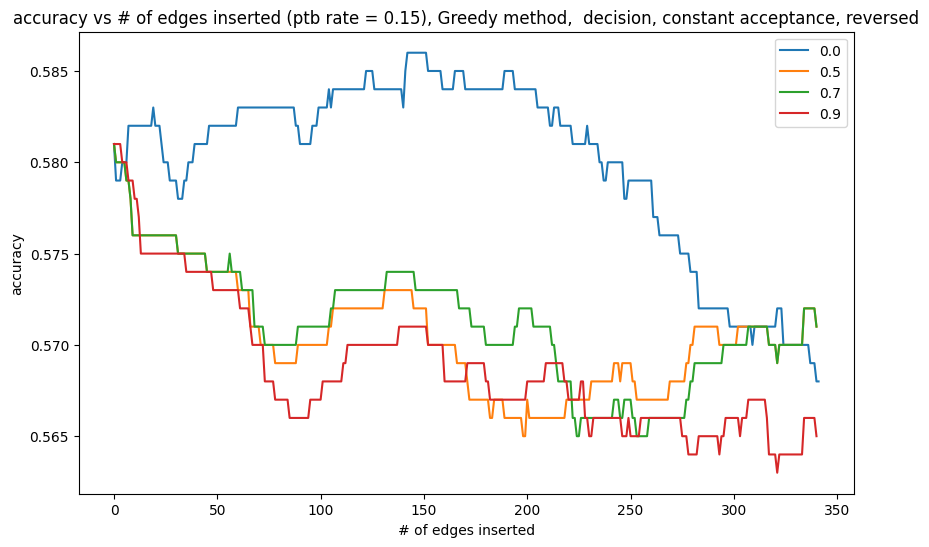

In [14]:
# plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "reversed")

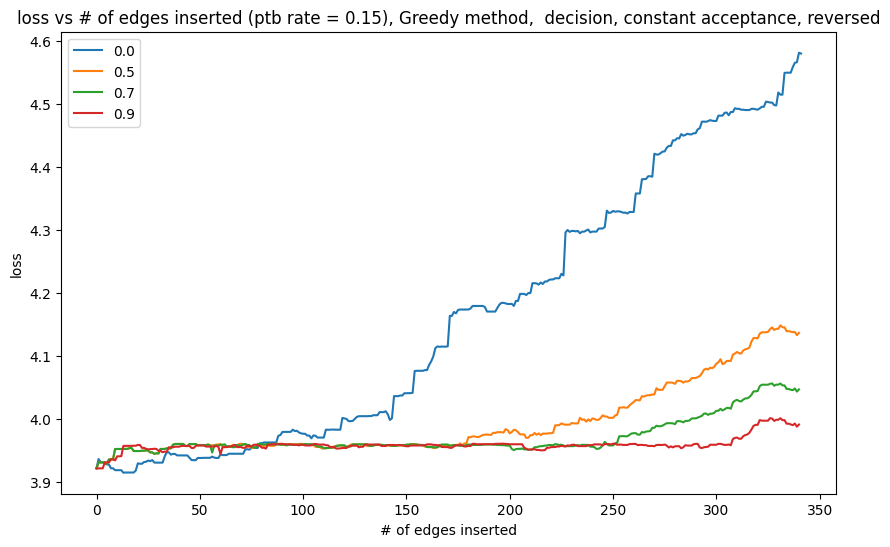

In [15]:
# plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "reversed")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [16]:
# split_dic_decreasing_acc = defaultdict(list)
# itrs_two = defaultdict(int)
# split_dic_decreasing_loss = defaultdict(list)

In [17]:
# for s in splits:
#     if s == 0.0:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
#     else:
#         split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/170 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 6, Selected: 0
Attempt: 7, Selected: 0
Attempt: 8, Selected: 0
Attempt: 9, Selected: 0
Attempt: 9, Selected: 0
Attempt: 10, Selected: 0
Attempt: 11, Selected: 0
Attempt: 12, Selected: 0
Attempt: 13, Selected: 0
Attempt: 14, Selected: 0
Attempt: 15, Selected: 0
Attempt: 16, Selected: 0
Attempt: 17, Selected: 0
Attempt: 18, Selected: 0
Attempt: 19, Selected: 0
Attempt: 33, Selected: 10
Attempt: 34, Selected: 10
Attempt: 35, Selected: 10
Attempt: 49, Selected: 20
Attempt: 61, Selected: 30
Attempt: 74, Selected: 40
Attempt: 84, Selected: 50
Attempt: 95, Selected: 60
Attempt: 108, Selected: 70
Attempt: 121, Selected: 80
Attempt: 122, Selected: 80
Attempt: 136, Selected: 90
Attempt: 148, Selected: 100
Attempt: 159, Selected: 110
Attempt: 171, Selected: 120
Attempt: 181, Selected: 130
Attempt: 191, Selected: 140
Attempt: 202, Selected: 150
At

Peturbing graph...:   0%|          | 0/102 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 6, Selected: 0
Attempt: 7, Selected: 0
Attempt: 20, Selected: 10
Attempt: 31, Selected: 20
Attempt: 32, Selected: 20
Attempt: 33, Selected: 20
Attempt: 34, Selected: 20
Attempt: 35, Selected: 20
Attempt: 50, Selected: 30
Attempt: 62, Selected: 40
Attempt: 76, Selected: 50
Attempt: 86, Selected: 60
Attempt: 97, Selected: 70
Attempt: 111, Selected: 80
Attempt: 124, Selected: 90
Attempt: 136, Selected: 100
Attempt: 148, Selected: 110
Attempt: 159, Selected: 120
Attempt: 170, Selected: 130
Attempt: 180, Selected: 140
Attempt: 190, Selected: 150
Attempt: 201, Selected: 160
Attempt: 212, Selected: 170
Attempt: 229, Selected: 180
Attempt: 239, Selected: 190
Attempt: 249, Selected: 200
Attempt: 259, Selected: 210
Attempt: 269, Selected: 220
Attempt: 279, Selected: 230


Peturbing graph...:   0%|          | 0/34 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 6, Selected: 0
Attempt: 7, Selected: 0
Attempt: 21, Selected: 10
Attempt: 38, Selected: 20
Attempt: 39, Selected: 20
Attempt: 54, Selected: 30
Attempt: 55, Selected: 30
Attempt: 65, Selected: 40
Attempt: 79, Selected: 50
Attempt: 89, Selected: 60
Attempt: 100, Selected: 70
Attempt: 101, Selected: 70
Attempt: 113, Selected: 80
Attempt: 129, Selected: 90
Attempt: 140, Selected: 100
Attempt: 152, Selected: 110
Attempt: 164, Selected: 120
Attempt: 175, Selected: 130
Attempt: 185, Selected: 140
Attempt: 196, Selected: 150
Attempt: 197, Selected: 150
Attempt: 210, Selected: 160
Attempt: 224, Selected: 170
Attempt: 236, Selected: 180
Attempt: 246, Selected: 190
Attempt: 256, Selected: 200
Attempt: 267, Selected: 210
Attempt: 277, Selected: 220
Attempt: 287, Selected: 230
Attempt: 298, Selected: 240
Attempt: 308, Selected: 250
Attempt: 318, Se

In [18]:
# record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CITESEER, AcceptFn.INCREASING, SelectFn.NONE, Reverse.REVERSED)
# record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"citeseer"}_{"increasing"}_{"reversed"}_results.pkl')

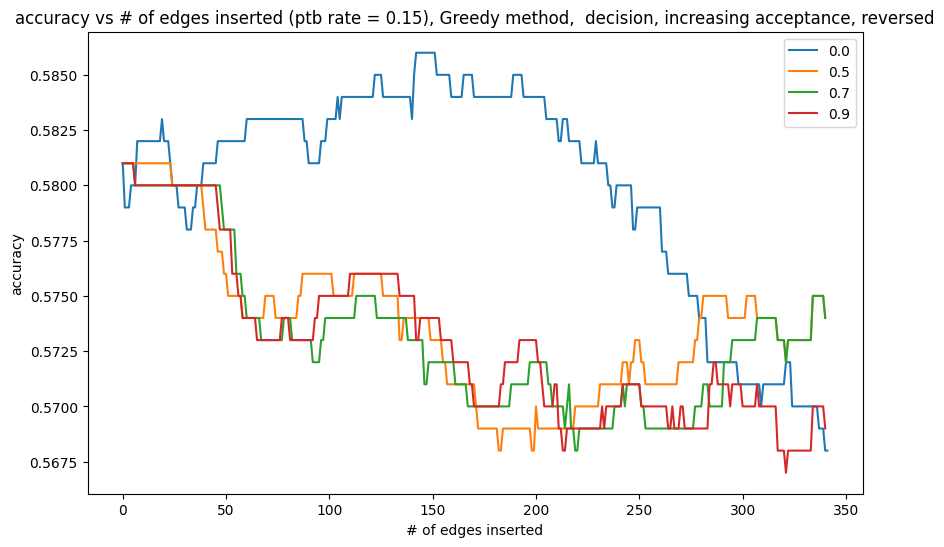

In [19]:
# plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "reversed")

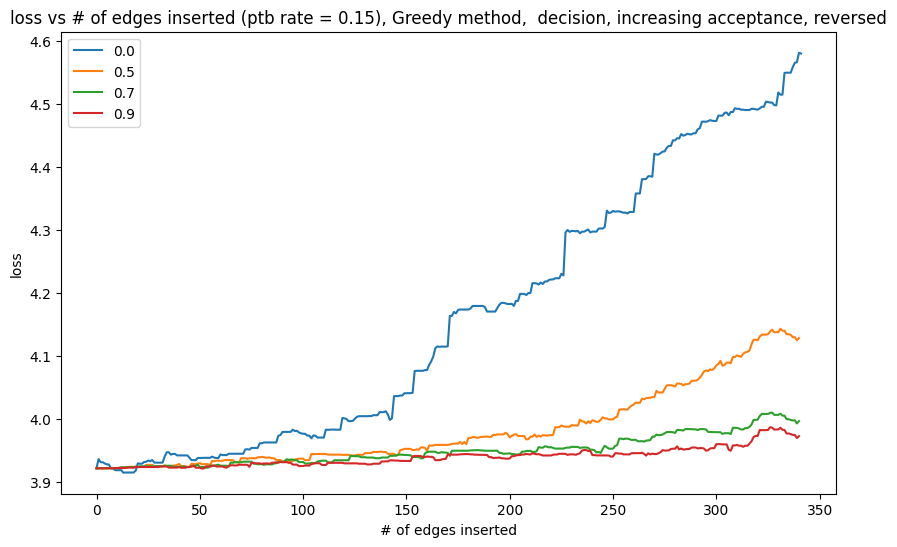

In [20]:
# plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "reversed")

# regular, secondary attack, not reversed

In [12]:
# splits = [0.0, 0.5, 0.7, 0.9]
splits = [0.0, 0.5]
# splits = [0.9]
split_dic_acc = defaultdict(defaultdict(list))
split_dic_loss = defaultdict(defaultdict(list))
itrs_one = defaultdict(defaultdict(int))

In [13]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_acc[s][j], split_dic_loss[s][j], itrs_one[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_acc[s][j], split_dic_loss[s][j], itrs_one[s][j] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/227 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 22, Selected: 10
Attempt: 48, Selected: 20
Attempt: 85, Selected: 30
Attempt: 86, Selected: 30
Attempt: 110, Selected: 40
Attempt: 111, Selected: 40
Attempt: 166, Selected: 50
Attempt: 167, Selected: 50
Attempt: 168, Selected: 50
Attempt: 169, Selected: 50
Attempt: 170, Selected: 50
Attempt: 171, Selected: 50
Attempt: 172, Selected: 50
Attempt: 173, Selected: 50
Attempt: 174, Selected: 50
Attempt: 175, Selected: 50
Attempt: 242, Selected: 60
Attempt: 243, Selected: 60
Attempt: 244, Selected: 60
Attempt: 245, Selected: 60
Attempt: 246, Selected: 60
Attempt: 307, Selected: 70
Attempt: 308, Selected: 70
Attempt: 309, Selected: 70
Attempt: 310, Selected: 70
Attempt: 380, Selected: 80
Attempt: 381, Selected: 80
Attempt: 382, Selected: 80
Attempt: 415, Selected: 90
Attempt: 416, Selected: 90
Attempt: 417, Selected: 90
Attempt: 418, Selected: 90
Attempt: 419, Selected: 90
Attempt: 420, Selected: 90
Attempt: 421, Selected: 90
Attempt: 422, Selected: 90
Attempt:

Peturbing graph...:   0%|          | 0/238 [00:00<?, ?it/s]

In [14]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CITESEER, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"citeseer"}_{"constant"}_{"attacked"}_results.pkl')

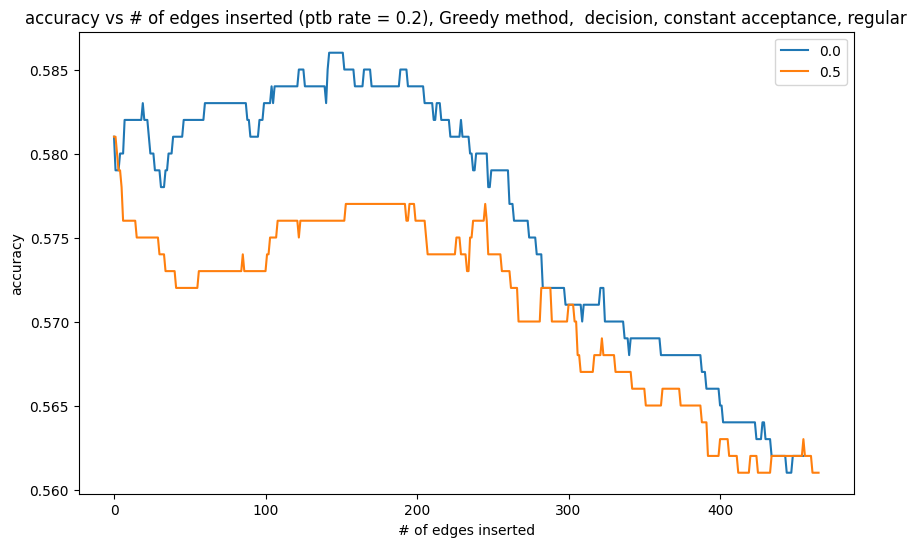

In [15]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "regular")

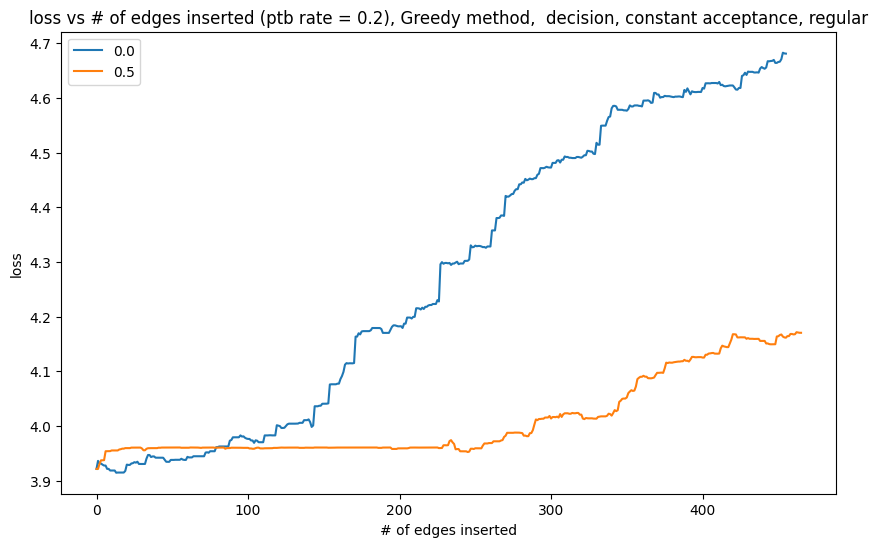

In [16]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "regular")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [17]:
split_dic_decreasing_acc = defaultdict(defaultdict(list))
itrs_two = defaultdict(defaultdict(int))
split_dic_decreasing_loss = defaultdict(defaultdict(list))

In [18]:
for s in splits:
    for j in range(trials):
        if s == 0.0:
            split_dic_decreasing_acc[s][j], split_dic_decreasing_loss[s][j], itrs_two[s][j] = full_metattack_acc[j], full_metattack_loss[j], full_metattack_itrs[j]
        else:
            split_dic_decreasing_acc[s][j], split_dic_decreasing_loss[s][j], itrs_two[s][j] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/227 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 41, Selected: 10
Attempt: 42, Selected: 10
Attempt: 43, Selected: 10
Attempt: 44, Selected: 10
Attempt: 45, Selected: 10
Attempt: 46, Selected: 10
Attempt: 47, Selected: 10
Attempt: 71, Selected: 20
Attempt: 72, Selected: 20
Attempt: 73, Selected: 20
Attempt: 74, Selected: 20
Attempt: 96, Selected: 30
Attempt: 97, Selected: 30
Attempt: 118, Selected: 40
Attempt: 119, Selected: 40
Attempt: 120, Selected: 40
Attempt: 159, Selected: 50
Attempt: 218, Selected: 60
Attempt: 219, Selected: 60
Attempt: 220, Selected: 60
Attempt: 221, Selected: 60
Attempt: 222, Selected: 60
Attempt: 245, Selected: 70
Attempt: 276, Selected: 80
Attempt: 277, Selected: 80
Attempt: 278, Selected: 80
Attempt: 311, Selected: 90
Attempt: 312, Selected: 90
Attempt: 313, Selected: 90
Attempt: 314, Selected: 90
Attempt: 315, Selected: 90
Attempt: 316, Selected: 90
Attempt: 317, Selected: 90
Attempt: 350, Selected: 100
Attempt: 351, Selected: 100
Attempt: 395, Selected: 110
Attempt: 396, 

Peturbing graph...:   0%|          | 0/238 [00:00<?, ?it/s]

In [19]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CITESEER, AcceptFn.INCREASING, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"citeseer"}_{"increasing"}_{"attacked"}_results.pkl')

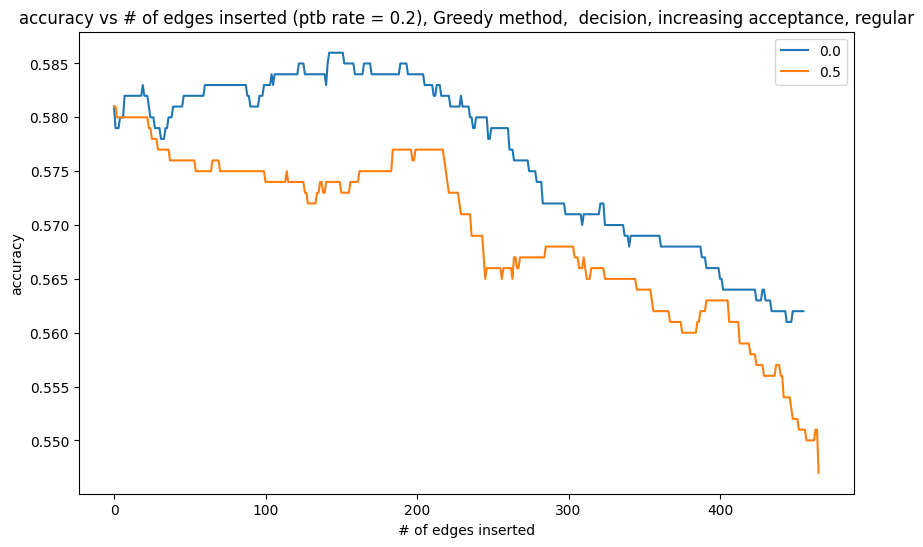

In [20]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "regular")

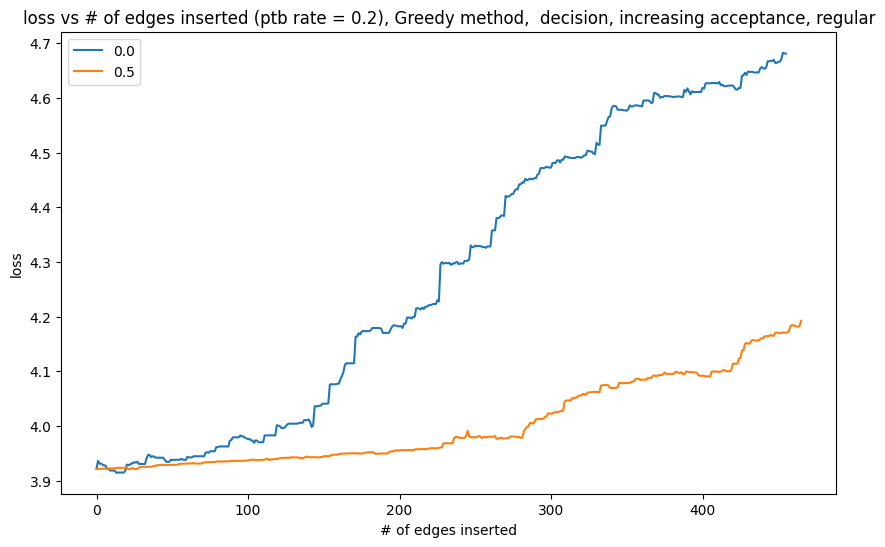

In [21]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "regular")